In [46]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
import copy

# Generate synthetic dataset
random_state = 42
np.random.seed(random_state)
X = np.random.rand(100, 10) # 100 datapoints of 10 features each
y = np.random.randint(0, 2, size = 100) # binary classification labels

# Initialize arrays for storing weights
initial_weights = []
final_weights = []
diff_weights = []


class DynamicDataset(Dataset):
    def __init__(self, data):
        # X: (N, 9), Y: (N, 6)
        self.X = data['X'].astype(np.float32)
        self.Y = data['Y'].astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

#define model
class NeuralNet(nn.Module):
    # ---
    # Your code goes here
    def __init__(self, input_dim, units):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, units)
        self.layer2 = nn.Linear(units, 1)

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

def train(model, train_loader):
    model.train()
    train_loss = 0.0

    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        train_prediction = model.forward(features)
        labels = labels.view(-1, 1)
        # print(
        #     f"prediction: {train_prediction}, and its shape: {train_prediction.size()}")
        # print(f"ground_truth: {labels}, and its shape: {labels.size()}")
        loss = criterion(train_prediction, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # print(f"train loss: {train_loss/(i+1)}")
    # ---
    train_loss /= (i + 1)
    return train_loss

def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
      for i, data in enumerate(test_loader):
          features = data[0]
          labels = data[1]
          test_prediction = model.forward(features)
          loss = criterion(test_prediction, labels)
          test_loss += loss.item()
    print(f"test loss: {test_loss/(i+1)}\n")
    # ---
    return test_loss

# We are only using CPU, and GPU is not allowed.
device = torch.device("cpu")
# torch.manual_seed(random_state)

data = {"X":X, "Y":y}
dataset = DynamicDataset(data)
batch_size = 1
train_loader = torch.utils.data.DataLoader(
    dataset, shuffle=True, batch_size=batch_size)
# The name of the directory to save all the checkpoints
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
model_dir = os.path.join('models', timestr)

# Define the range of units in the first layer
unit_range = np.arange(100, 10050, 10)

for units in unit_range:
    # Define the model architecture
    print(f"Number of units: {units}")
    model = NeuralNet(input_dim=10, units=units)
    model = model.to(device)
    
    # Print initial weights
    # initial_weights.append(model.layers[0].get_weights()[0])
    # initial_model_copy = type(model)(input_dim=10, units=units)
    # initial_model_copy.load_state_dict(model.state_dict())
    # initial_layer_weights = initial_model_copy.state_dict()
    initial_layer_weights = copy.deepcopy(model.state_dict())  # to keep it seperate from its internal pointers
    initial_weights.append(initial_layer_weights)
    # print(f"initial layer weights: \n{initial_layer_weights}")
    # Compile the model with a loss function and an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    criterion = nn.BCELoss()

    epochs = 2000
    previous_lowest_train_loss = float('inf')
    for epoch in range(1, 1 + epochs):
        # print(f"epoch number {epoch}")
        train_loss = train(model=model, train_loader=train_loader)
        # print(f"train loss: {train_loss}, at epoch: {epoch}")
        if train_loss <= 0.005:
            print(f"train loss: {train_loss}, at epoch: {epoch}\n")
            break
    final_layer_weights = model.state_dict()
    final_weights.append(final_layer_weights)
    # # print(f"final layer weights: \n{final_layer_weights}")
    # layer1_max_difference = torch.max(final_weights[-1]["layer1.weight"] - initial_weights[-1]["layer1.weight"])
    # layer2_max_difference = torch.max(final_weights[-1]["layer2.weight"] - initial_weights[-1]["layer2.weight"])
    # print(f"layer 1 diff: {layer1_max_difference}")
    # print(f"layer 2 diff: {layer2_max_difference}")
    # max_difference = max(layer1_max_difference, layer2_max_difference)
    # print(f"the max difference is {max_difference} for {units} units\n")
    # diff_weights.append(max_difference)


Number of units: 100
train loss: 0.004721559379502338, at epoch: 329

Number of units: 110
train loss: 0.0047632742333973965, at epoch: 320

Number of units: 120
train loss: 0.004850271885238726, at epoch: 344

Number of units: 130
train loss: 0.004852562177304804, at epoch: 312

Number of units: 140
train loss: 0.004703225292184925, at epoch: 299

Number of units: 150
train loss: 0.004902697014192086, at epoch: 284

Number of units: 160
train loss: 0.004759163043708838, at epoch: 282

Number of units: 170
train loss: 0.00488559928937093, at epoch: 259

Number of units: 180
train loss: 0.004743049303292537, at epoch: 263

Number of units: 190
train loss: 0.004710286336493254, at epoch: 239

Number of units: 200
train loss: 0.004941364534004151, at epoch: 252

Number of units: 210
train loss: 0.004923039954807109, at epoch: 237

Number of units: 220
train loss: 0.004862780243781231, at epoch: 258

Number of units: 230
train loss: 0.004839528424322452, at epoch: 230

Number of units: 240

In [47]:
import pickle
weights = {"initial weights" : initial_weights, "final weights": final_weights}
pickle.dump(weights, open( "data_big.pkl", "wb" ) )

In [90]:
# import matplotlib.pyplot as plt

# max_vals = []

# for i in range(len(diff_weights)):
#     max_vals.append(diff_weights[i])
    
# # set the size of the figure
# fig, ax = plt.subplots(figsize = (8, 6))

# # create the plot
# ax.plot(unit_range, max_vals, linestyle = '-', marker = 'o')

# # set the title and axis labels
# ax.set_title('Maximum difference in weights vs neurons')
# ax.set_xlabel('Number of neurons')
# ax.set_ylabel('Maximum weight difference')
# ax.set_ylim([0, 2.5])
# ax.set_xlim([100, 1000])

# # calculate line of best fit
# coefficients = np.polyfit(unit_range, max_vals, 2)
# line_of_best_fit = coefficients[0] * unit_range**2 + coefficients[1] * unit_range + coefficients[2]

# # plot line of best fit 
# ax.plot(unit_range, line_of_best_fit, linestyle = '--', color = 'red')

# # display the plot
# plt.show()

Personal progress:
- reimplement code in pytorch
- added early stoping at training loss of 0.005
- added data saving in pickle file format for futher processing
- implemented Frobenius norm of layer weights and unit calculation to plot results


Next steps:
- classify bound of significant movement on synthetic data
- 2 layer neural nets
- find network under our bound of significance of lazy training
- take that network
- add depth
- find how many neurons we can narrow it by with 2 layers instead of 1
- switch to MNIST and do the same

In [2]:
import pickle
data = pickle.load(open("results/data_big.pkl", "rb"))
initial = data["initial weights"]
final = data["final weights"]
size = len(final)

In [3]:
print(size)

995


In [8]:
import torch
import numpy as np 
norms = []
for i in range(size):
    # Compute Frobenius norm between A and B
    fro_norm_1 = torch.norm(
        initial[i]["layer1.weight"]-final[i]["layer1.weight"], p='fro')
    fro_norm_2 = torch.norm(
        initial[i]["layer2.weight"]-final[i]["layer2.weight"], p='fro')
    fro_norm = fro_norm_1 + fro_norm_2
    norms.append(fro_norm)


In [9]:
count = 0
unit_range = np.arange(100, 10050, 10)
for units in unit_range:
    norms[count] = norms[count] / units 
    count = count + 1

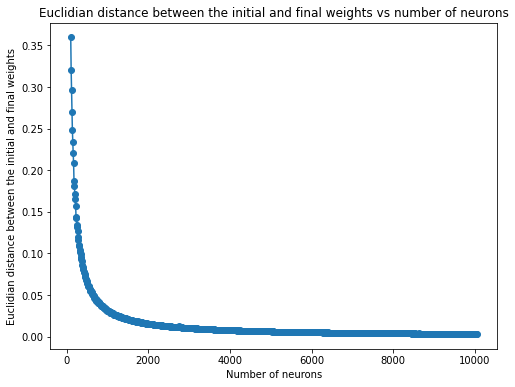

In [10]:
import matplotlib.pyplot as plt

# set the size of the figure
fig, ax = plt.subplots(figsize=(8, 6))
# create the plot
ax.plot(unit_range, norms, linestyle='-', marker='o')

# set the title and axis labels
ax.set_title('Euclidian distance between the initial and final weights vs number of neurons')
ax.set_xlabel('Number of neurons')
ax.set_ylabel('Euclidian distance between the initial and final weights')


# display the plot
plt.show()

find the percantage changes in euclidian distance between neurons
- 10

Mean: 0.01515685
Median: 0.006108641
Variance: 0.0009900859
Standard deviation: 0.03146563


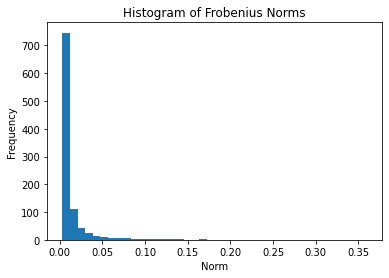

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a large set of Frobenius norms
# norms = np.random.normal(loc=10, scale=2, size=10000)
norms = np.array(norms)


# Compute descriptive statistics
mean_norm = np.mean(norms)
median_norm = np.median(norms)
var_norm = np.var(norms)
std_norm = np.std(norms)

# Print descriptive statistics
print('Mean:', mean_norm)
print('Median:', median_norm)
print('Variance:', var_norm)
print('Standard deviation:', std_norm)

# Plot a histogram of the Frobenius norms
plt.hist(norms, bins=40)
plt.title('Histogram of Frobenius Norms')
plt.xlabel('Norm')
plt.ylabel('Frequency')
plt.show()


   Lower Bound  Upper Bound  number of neurons
0        0.150        0.360                100
1        0.150        0.360                220
2        0.015        0.150                230
3        0.015        0.150               2050
4        0.000        0.015               2010
5        0.000        0.015              10040


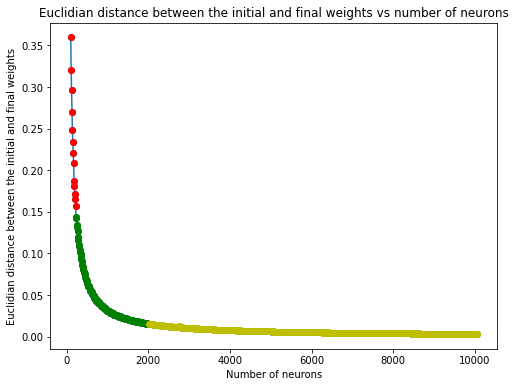

In [55]:
import pandas as pd


lb1 = 0.15
ub1 = 0.36
idx_1 = np.where((norms > lb1) & (norms < ub1))[0]
translated_idx_1 = unit_range[idx_1]

lb2 = 0.015
ub2 = 0.15
idx_2 = np.where((norms > lb2) & (norms < ub2))[0]
translated_idx_2 = unit_range[idx_2]

lb3 = 0.0
ub3 = 0.015
idx_3 = np.where((norms > lb3) & (norms < ub3))[0]
translated_idx_3 = unit_range[idx_3]

# Create a table of threshold values and corresponding indices
lower_bound = []
upper_bound = []
translated_idx = []
def fill_bounds(lb, ub, translate):
    for i, val in enumerate(translate):
        if i == 0:
            lower_bound.append(lb)
            upper_bound.append(ub)
            translated_idx.append(val)
        elif i == len(translate) - 1:
            lower_bound.append(lb)
            upper_bound.append(ub)
            translated_idx.append(val)
fill_bounds(lb1, ub1, translated_idx_1)
fill_bounds(lb2, ub2, translated_idx_2)
fill_bounds(lb3, ub3, translated_idx_3)
df = pd.DataFrame({'Lower Bound': lower_bound,
                  'Upper Bound': upper_bound, 'number of neurons': translated_idx})

# threshold = 0.001
# idx = np.where(norms > threshold)[0]

# # Create a table of threshold values and corresponding indices
# df = pd.DataFrame({'Threshold': threshold, 'Index': idx})

# Print the table
print(df)

# set the size of the figure
fig, ax = plt.subplots(figsize=(8, 6))
# create the plot
ax.plot(unit_range, norms, linestyle='-', marker='o')
ax.plot(translated_idx_1, norms[idx_1], 'ro')
ax.plot(translated_idx_2, norms[idx_2], 'go')
ax.plot(translated_idx_3, norms[idx_3], 'yo')
# set the title and axis labels
ax.set_title(
    'Euclidian distance between the initial and final weights vs number of neurons')
ax.set_xlabel('Number of neurons')
ax.set_ylabel('Euclidian distance between the initial and final weights')

plt.show()


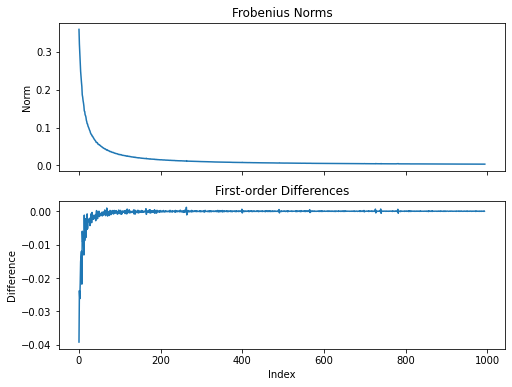

In [12]:
# Compute the first-order differences
diffs = np.diff(norms)

# Plot the norms and differences
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].plot(norms)
ax[0].set_ylabel('Norm')
ax[0].set_title('Frobenius Norms')
ax[1].plot(diffs)
ax[1].set_ylabel('Difference')
ax[1].set_xlabel('Index')
ax[1].set_title('First-order Differences')
plt.show()


In [16]:
# print(diffs)

    Lower Bound  Upper Bound  Index
0        0.0001            1     43
1        0.0001            1     63
2        0.0001            1     68
3        0.0001            1     76
4        0.0001            1     81
..          ...          ...    ...
70       0.0001            1    729
71       0.0001            1    739
72       0.0001            1    781
73       0.0001            1    813
74       0.0001            1    865

[75 rows x 3 columns]


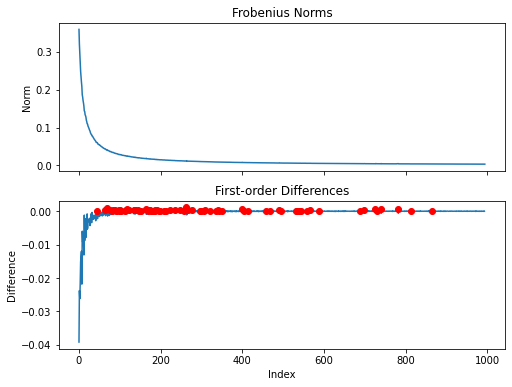

In [34]:
import pandas as pd


lower_bound = 0.0001
upper_bound = 1
idx = np.where((diffs > lower_bound) & (diffs < upper_bound))[0]

# Create a table of threshold values and corresponding indices
df = pd.DataFrame({'Lower Bound': lower_bound,
                  'Upper Bound': upper_bound, 'Index': idx})

# threshold = 0.001
# idx = np.where(np.abs(diffs) > threshold)[0]

# # Create a table of threshold values and corresponding indices
# df = pd.DataFrame({'Threshold': threshold, 'Index': idx})

# Print the table
print(df)
# Plot the norms and differences
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].plot(norms)
ax[0].set_ylabel('Norm')
ax[0].set_title('Frobenius Norms')
ax[1].plot(diffs)
ax[1].plot(idx, diffs[idx], 'ro')
ax[1].set_ylabel('Difference')
ax[1].set_xlabel('Index')
ax[1].set_title('First-order Differences')
plt.show()
